Find the optimal number of hidden neurons for the first depth and widths of the neural network designed in Question 1 and 2.

#### Plot the mean cross-validation accuracies on the final epoch for at least 8 different combinations of different depth (limit to 1-3 layers) and widths (limit to 64, 128 or 256 neurons) using a scatter plot. Continue using 5-fold cross validation on the training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot. [optional + 2 marks] Implement an alternative approach that searches through these combinations that could significantly reduce the computational time but achieve similar search results, without enumeration all the possibilities.



This might take a while to run, approximately 30 - 60 min, so plan your time carefully.

1.Firstly, we import relevant libraries.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed, MLP, CustomDataset, split_dataset, preprocess_dataset, set_seed, loss_fn

# setting seed
set_seed()

2.To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
from common_utils import MLP, CustomDataset, set_seed, loss_fn

df = pd.read_csv('simplified.csv')  # Replace with the correct path

df['label'] = df['filename'].apply(lambda x: 1 if '_pos_' in x else 0)  # Binary labels (1 for positive, 0 for negative)

columns_to_drop = ['filename']

df_train, y_train, df_test, y_test = split_dataset(df, columns_to_drop, test_size=0.2, random_state=42)

X_train_scaled, X_test_scaled = preprocess_dataset(df_train, df_test)

neuron_combinations = [(1, 64), (1, 128), (1, 256), (2, 64), (2, 128), (2, 256), (3, 64), (3, 128), (3, 256)]

In [3]:
def build_model(depth, width, input_size):
    layers = []
    for i in range(depth):
        if i == 0:
            layers.append(nn.Linear(input_size, width))
        else:
            layers.append(nn.Linear(width, width))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.2))
    layers.append(nn.Linear(width, 1))
    layers.append(nn.Sigmoid())
    return nn.Sequential(*layers)

3.Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [4]:
def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):

    # YOUR CODE HERE

    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [5]:
def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):
    train_dataset = CustomDataset(X_train_scaled, y_train2)
    val_dataset = CustomDataset(X_val_scaled, y_val2)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_accuracies, train_losses = [], []
    test_accuracies, test_losses = [], []
    times = []

    for epoch in range(10):  # Train for 10 epochs
        model.train()
        correct_train, total_train, train_loss = 0, 0, 0
        start_time = time.time()
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct_train += (preds == y_batch).sum().item()
            total_train += y_batch.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)
        
        model.eval()
        correct_test, total_test, test_loss = 0, 0, 0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch).squeeze()
                loss = loss_fn(outputs, y_batch)
                test_loss += loss.item()
                preds = (outputs > 0.5).float()
                correct_test += (preds == y_batch).sum().item()
                total_test += y_batch.size(0)

        test_losses.append(test_loss / len(val_loader))
        test_accuracies.append(correct_test / total_test)
        times.append(time.time() - start_time)
    
    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [6]:
def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):
    cross_validation_accuracies = []
    cross_validation_times = []
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for parameter in parameters:
        fold_accuracies = []
        fold_times = []
        
        for train_idx, val_idx in kf.split(X_train):
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

            if mode == 'num_neurons':
                depth, width = parameter
                model = build_model(depth, width, X_train_fold.shape[1])

            # Train the model
            _, _, test_accuracies, _, times = train(model, X_train_fold, y_train_fold, X_val_fold, y_val_fold, batch_size)
            fold_accuracies.append(np.mean(test_accuracies))
            fold_times.append(np.mean(times))
        
        cross_validation_accuracies.append(np.mean(fold_accuracies))
        cross_validation_times.append(np.mean(fold_times))
    
    return cross_validation_accuracies, cross_validation_times

In [7]:
optimal_bs = 128  # Example value, use the optimal batch size from previous tuning

cross_validation_accuracies = []
cross_validation_times = []

for depth, width in neuron_combinations:
    accuracies, times = find_optimal_hyperparameter(X_train_scaled, y_train, [(depth, width)], 'num_neurons', optimal_bs)
    cross_validation_accuracies.append(accuracies[0])
    cross_validation_times.append(times[0])

4. Plot the mean cross-validation accuracies on the final epoch for at least 8 different combinations of different depth (limit to 1-3 layers) and widths (limit to 64, 128 or 256 neurons) using a scatter plot. 

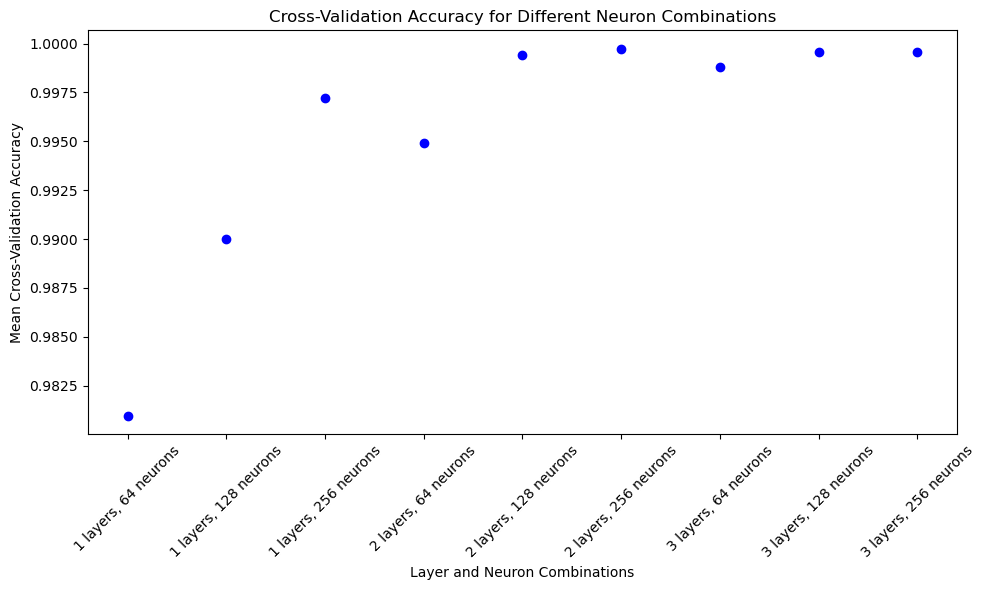

In [8]:
# YOUR CODE HERE

plt.figure(figsize=(10, 6))
for i, (depth, width) in enumerate(neuron_combinations):
    plt.scatter(f'{depth} layers, {width} neurons', cross_validation_accuracies[i], color='b')

plt.xlabel('Layer and Neuron Combinations')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Cross-Validation Accuracy for Different Neuron Combinations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

5. Select the optimal combination for the depth and width. State the rationale for your selection.

In [9]:
optimal_idx = np.argmax(cross_validation_accuracies)
optimal_combination = neuron_combinations[optimal_idx]
reason = f"The optimal combination is {optimal_combination[0]} layers with {optimal_combination[1]} neurons because it provides the highest cross-validation accuracy."

print(f"Optimal Combination: {optimal_combination}")
print(f"Reason: {reason}")


Optimal Combination: (2, 256)
Reason: The optimal combination is 2 layers with 256 neurons because it provides the highest cross-validation accuracy.


6.Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.


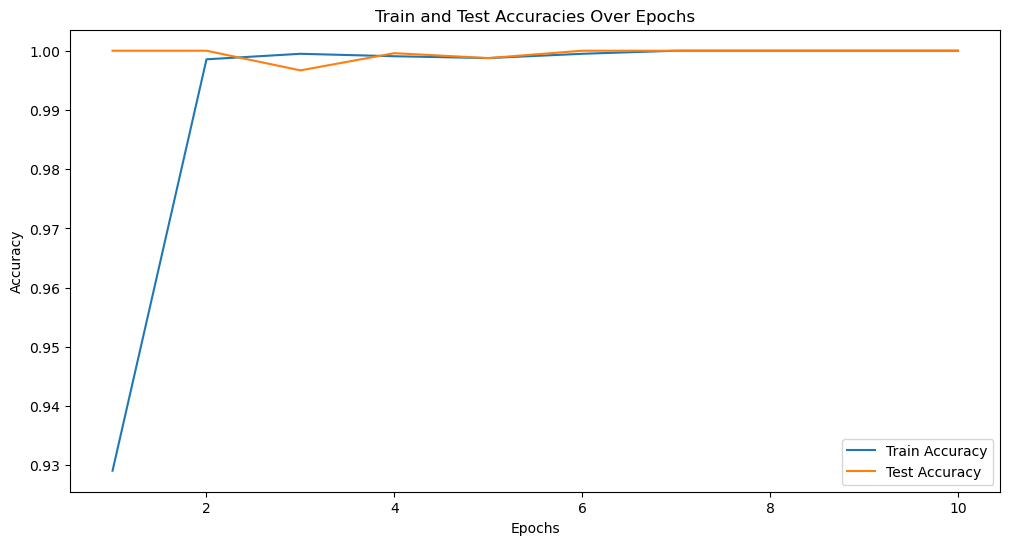

In [10]:
# YOUR CODE HERE
depth, width = optimal_combination
model = build_model(depth, width, X_train_scaled.shape[1])

train_accuracies, train_losses, test_accuracies, test_losses, _ = train(
    model, X_train_scaled, y_train, X_test_scaled, y_test, optimal_bs)

torch.save(model.state_dict(), 'mlp_pretrained_weights.pth')

epochs = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracies Over Epochs")
plt.legend()
plt.show()

7.As you've astutely observed, we're facing a significant challenge in enumerating all possible combinations of widths and depths and searching over them. Given the circumstances, could you explore and implement a more efficient method for searching through these combinations that could significantly reduce the computational time but achieve similar search results?

When optimizing neural network architectures, enumerating all possible combinations of hyperparameters (such as the number of layers and neurons) can be computationally expensive. An efficient way to search through the hyperparameter space without evaluating every configuration is Random Search.

In Random Search, instead of exhaustively testing all combinations, we randomly sample a subset of configurations from the full search space. This technique is often surprisingly effective because it explores a wide variety of architectures without spending excessive computational resources on every possible combination.

Pros of Random Search:

* Efficiency: Randomly selecting configurations reduces the computational burden significantly compared to a full grid search, where all combinations are tested.
* Exploration: Random search samples across the entire hyperparameter space, ensuring that a diverse set of architectures is evaluated, which often leads to near-optimal solutions.
* Simplicity: The approach is easy to implement and doesn't require complex optimization techniques.

In the code implementation below, we define a random search function that samples a fixed number of neuron configurations (in terms of depth and width) and evaluates them. We perform 5-fold cross-validation on the randomly selected architectures and select the configuration with the highest cross-validation accuracy.

In [11]:
# YOUR CODE HERE

# Step 1: Define a random search function to sample random neuron configurations
def random_search(neuron_combinations, num_samples=5):
    """
    Randomly samples from the provided neuron combinations.
    
    Parameters:
    - neuron_combinations: List of all possible neuron configurations (depth, width).
    - num_samples: Number of configurations to randomly sample.
    
    Returns:
    - random_combinations: A subset of randomly sampled neuron configurations.
    """
    random_combinations = random.sample(neuron_combinations, num_samples)
    return random_combinations

In [12]:
# Step 2: Perform random search over a subset of neuron combinations
neuron_combinations = [(1, 64), (1, 128), (1, 256), (2, 64), (2, 128), (2, 256), (3, 64), (3, 128), (3, 256)]
num_samples = 5  # Select 5 random configurations
random_combinations = random_search(neuron_combinations, num_samples)

# Initialize lists to store cross-validation accuracies and times for random combinations
cross_validation_accuracies_random = []
cross_validation_times_random = []

In [13]:
# Step 3: Perform hyperparameter tuning on the randomly selected neuron combinations
for depth, width in random_combinations:
    accuracies, times = find_optimal_hyperparameter(X_train_scaled, y_train, [(depth, width)], 'num_neurons', optimal_bs)
    cross_validation_accuracies_random.append(accuracies[0])
    cross_validation_times_random.append(times[0])


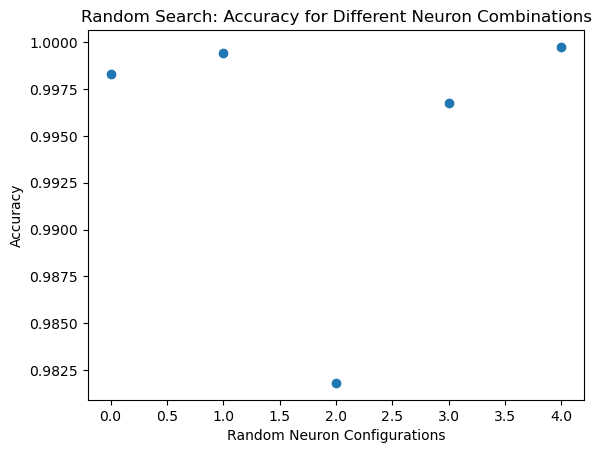

In [14]:
# Step 4: Plot the random search results
plt.scatter(range(len(random_combinations)), cross_validation_accuracies_random)
plt.xlabel("Random Neuron Configurations")
plt.ylabel("Accuracy")
plt.title("Random Search: Accuracy for Different Neuron Combinations")
plt.show()

In [15]:
# Step 5: Select the optimal configuration from the random search
optimal_idx_random = np.argmax(cross_validation_accuracies_random)
optimal_combination_random = random_combinations[optimal_idx_random]
print(f"Optimal Combination from Random Search: {optimal_combination_random}")

Optimal Combination from Random Search: (2, 128)
